# 实验三：参数估计 & 非参数估计

## 实验要求

### 基本要求
生成两个各包含 $N=1200$ 个二维随机向量的数据集合 $X_1$ 和 $X_2$，数据集合中随机向量来自于三个分布模型，分别满足均值向量$μ_1 = [1,4],μ_2 = [4,1],μ_3 = [8,4]$和协方差矩阵$D_1 = D_2 = D_3 = 2I$，其中$I$是$2∗2$的单位矩阵。在生成数据集合 $X_1$时，假设来自三个分布模型的先验概率相同；而在生成数据集合 $X_2$ 时，先验概率如下：$p(w_1) = 0.6,p(w_2) = 0.1,p(w_3) = 0.3$ 
1. 在两个数据集合上分别应用“似然率测试规则” 、“最大后验概率规则” 进行分类实验，计算分类错误率，分析实验结果。
2. 在两个数据集合上分别应用 $h=1$ 时的方窗核函数或高斯核函数估计方法，应用“似然率测试规则”进行分类实验，计算分类错误率，分析实验结果。

### 中级要求
1. 根据初级要求中使用的一个核函数，在数据集 $X_2$ 上应用交叉验证法，在 $h∈[0.1,0.5,1,1.5,2]$ 中寻找最优的h值。

### 高级要求
1. 任选一个数据集，在该数据集上应用k-近邻概率密度估计，任选3个k值输出概率密度分布图。

## 生成数据集

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import copy
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# 生成正态分布数据
def Generate_Sample_Gaussian(mean, cov, P, label):
    '''
        mean 为均值向量
        cov 为方差矩阵a
        P 为单个类的先验概率
        return 单个类的数据集
    '''
    temp_num = round(1200 * P)
    x, y = np.random.multivariate_normal(mean, cov, temp_num).T
    z = np.ones(temp_num) * label
    X = np.array([x, y, z])
    return X.T

In [3]:
def Generate_DataSet_plot(mean, cov, P):
    # 画出不同先验对应的散点图
    xx = []
    label = 1
    for i in range(3):
        xx.append(Generate_Sample_Gaussian(mean[i], cov, P[i], label))
        label += 1
        i = i + 1
    # 画图
    plt.figure()
    for i in range(3):
        plt.plot(xx[i][:, 0], xx[i][:, 1], '.', markersize=4.)
        plt.plot(mean[i][0], mean[i][1], 'r*')
    plt.show()
    return xx

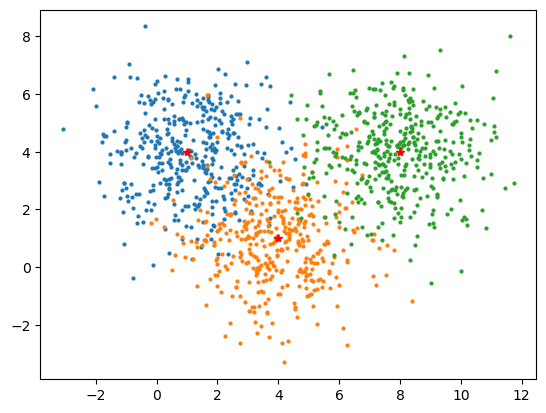

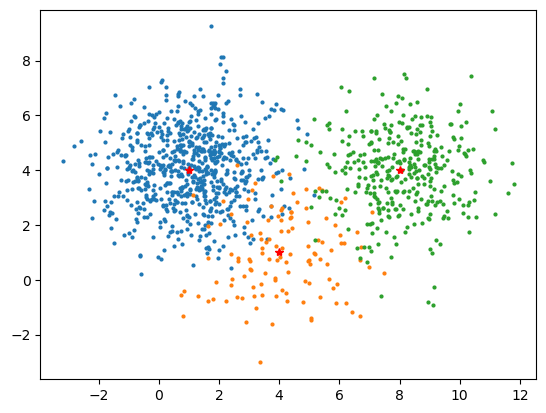

In [4]:
mean = np.array([[1, 4], [4, 1], [8, 4]])  # 均值数组
cov = [[2, 0], [0, 2]]  # 方差矩阵
num = 1200  # 样本个数
P1 = [1 / 3, 1 / 3, 1 / 3]  # 样本X1的先验概率
P2 = [0.6, 0.1, 0.3]  # 样本X2的先验概率
X1 = np.array(Generate_DataSet_plot(mean, cov, P1), dtype=object)
X2 = np.array(Generate_DataSet_plot(mean, cov, P2), dtype=object)
X1 = np.vstack(X1)
X2 = np.vstack(X2)

In [5]:
X1.shape, X2.shape  # 前两列是坐标，最后一列是标签

((1200, 3), (1200, 3))

## 基本要求

### 1. 似然率测试规则 、最大后验概率规则实现与分析

#### 高斯函数

In [6]:
# 高斯函数
def Gaussian_function(x, mu, cov):
    det_cov = np.linalg.det(cov)  # 计算方差矩阵的行列式
    inv_cov = np.linalg.inv(cov)  # 计算方差矩阵的逆
    # 计算概率p(x|w)
    p = 1 / (2 * np.pi * np.sqrt(det_cov)) * np.exp(-0.5 * np.dot(np.dot((x - mu), inv_cov), (x - mu).T))
    return p

#### 极大似然估计求均值和协方差矩阵

In [7]:
# 极大似然估计
def LikelyHood(X, label):
    X = copy.deepcopy(X)
    X = np.array([X[i] for i in range(X.shape[0]) if X[i][2] == label])[:, 0:2]
    mu = np.mean(X, axis=0)
    # python把向量转化成矩阵需要用reshape
    cov = np.array([np.dot((X[i] - mu).reshape(2,1), (X[i] - mu).reshape(1, 2)) for i in range(len(X))]).mean(axis=0)
    return mu, cov

#### 似然率测试规则

In [8]:
# 似然率测试规则
def LikelyHood_Test(X, labels):
    error_nums = 0
    mus = dict()
    covs = dict()
    for label in labels:
        mu, cov = LikelyHood(X, label)
        mus[label] = mu
        covs[label] = cov.astype('float64')
    for sample in X:
        p = np.zeros(len(labels))
        for i in range(len(labels)):
            p[i] = Gaussian_function(sample[0:2], mus[labels[i]], covs[labels[i]])
        exp_label = labels[np.argmax(p)]
        if exp_label != sample[2]:
            error_nums += 1
    return round(error_nums / X.shape[0], 10)

#### 最大后验概率规则

In [9]:
# 最大后验概率规则
def  MaxPosterior_Test(X, labels, P):
    error_nums = 0
    mus = dict()
    covs = dict()
    for label in labels:
        mu, cov = LikelyHood(X, label)
        mus[label] = mu
        covs[label] = cov.astype('float64')
    for sample in X:
        p = np.zeros(len(labels))
        for i in range(len(labels)):
            p[i] = Gaussian_function(sample[0:2], mus[labels[i]], covs[labels[i]]) * P[i]
        exp_label = labels[np.argmax(p)]
        if exp_label != sample[2]:
            error_nums += 1
    return round(error_nums / X.shape[0], 10)

#### 实验结果

In [10]:
print("分类错误率\n数据集\t似然率测试规则\t最大后验概率规则")
print(f"X1\t{LikelyHood_Test(X1, [1, 2, 3])}\t{MaxPosterior_Test(X1, [1, 2, 3], P1)}")
print(f"X2\t{LikelyHood_Test(X2, [1, 2, 3])}\t{MaxPosterior_Test(X2, [1, 2, 3], P2)}")

分类错误率
数据集	似然率测试规则	最大后验概率规则
X1	0.0816666667	0.0816666667
X2	0.0641666667	0.0366666667


#### 结果分析
若每类的先验概率相同，则似然率测试规则和最大后验概率规则的预测错误率相同。当先验概率不同时，最大后验概率测试规则的预测错误率更小。

### 2. 核函数结合似然率测试规则

#### 高斯核函数

In [11]:
def Gaussian_Kernel(x, X, h=1):
    # 计算概率p(x|w)
    p = (1 / (np.sqrt(2 * np.pi) * h)) * np.array([np.exp(-0.5 * np.dot(x - X[i][0:2], x - X[i][0:2]) / (h**2)) for i in range(len(X))]).mean()
    return p

#### 似然率测试规则

In [12]:
# 似然率测试规则结合Guass核函数
def LikelyHood_Test_Gauss(X, labels, h=1.0):
    w = dict()
    for label in labels:
        wl = [X[i] for i in range(X.shape[0]) if X[i][2] == label]
        w[label] = wl
    error_nums = 0
    for sample in X:
        p = np.zeros(len(labels))
        for i in range(len(labels)):
            p[i] = Gaussian_Kernel(sample[0:2], w[labels[i]], h)
        exp_label = labels[np.argmax(p)]
        if exp_label != sample[2]:
            error_nums += 1
    return round(error_nums / X.shape[0], 10)

#### 实验结果

In [13]:
print("分类错误率\n数据集\t似然率测试规则")
print(f"X1\t{LikelyHood_Test_Gauss(X1, [1, 2, 3])}")
print(f"X2\t{LikelyHood_Test_Gauss(X2, [1, 2, 3])}")

分类错误率
数据集	似然率测试规则
X1	0.0833333333
X2	0.0641666667


## 中级要求

### 留一法

In [14]:
# 留一法似然率测试规则
def LikelyHood_Test_Gauss_CrossValid(X, labels, h=1.0): 
    error_nums = 0
    cnt = 0
    for sample in X:
        temp_X = np.delete(X, cnt, axis=0)
        w = dict()
        for label in labels:
            wl = [temp_X[i] for i in range(temp_X.shape[0]) if temp_X[i][2] == label]
            w[label] = wl
        p = np.zeros(len(labels))
        for i in range(len(labels)):
            p[i] = Gaussian_Kernel(sample[0:2], w[labels[i]], h)
        exp_label = labels[np.argmax(p)]
        if exp_label != sample[2]:
            error_nums += 1
        cnt += 1
    return round(error_nums / X.shape[0], 10) 

In [15]:
hs = [0.1, 0.5, 1.0, 1.5, 2.0]
print("h\terror_rate")
for h in hs:
    error_rate = LikelyHood_Test_Gauss_CrossValid(X2, [1, 2, 3], h)
    print(f"{h}\t{error_rate}")

h	error_rate
0.1	0.0675
0.5	0.0633333333
1.0	0.065
1.5	0.0658333333
2.0	0.0633333333


### 结果分析
经过多次测试，发现初始数据不同，跑出来的最优的k不同。本次最优的k是0.5和2.0。

## 高级要求

### 距离函数

In [16]:
def distance(x,y):
    return np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2)

### K近邻算法

In [17]:
def Kneibor_Eval(X, labels, k):
    N_k = list()
    for i in range(len(labels)):
        N_k.append(0)
        N_k[i] = len([1 for sample in X if sample[2] == labels[i]])
    # 生成200*200=40000个采样点，每个采样点对应三类的不同概率
    p = np.zeros((200, 200, 3))
    # 在[-5,15]的范围内，以0.1为步长估计概率密度
    for i in range(200):
        for j in range(200):
            '''
            # 生成标准差距离
            # 根据第k个数据点的位置计算V
            # 找到前k个数据点的类别,分别加到对应类的权重上
            # 计算每个采样点的概率密度函数
            '''
            x = [-5 + 0.1 * i, -5 + 0.1 * j]
            dists = list()
            for sample in X:
                dists.append([distance(x, sample[0:2]), sample[2]])
            dists.sort(key=lambda x:x[0])
            V = np.pi * (dists[k - 1][0] ** 2)
            for _j in range(len(labels)):
                K_k = len([1 for _i in range(k) if dists[_i][1] == labels[_j]])
                p[i][j][_j] = (K_k / N_k[_j]) / V
    return p

### 实验结果

#### k = 10

In [18]:
k = 10

In [19]:
p = Kneibor_Eval(X1, [1, 2, 3], k)  # 获得概率密度估计

X, Y = np.mgrid[-5:15:200j, -5:15:200j]
Z0 = p[:, :, 0]
Z1 = p[:, :, 1]
Z2 = p[:, :, 2]

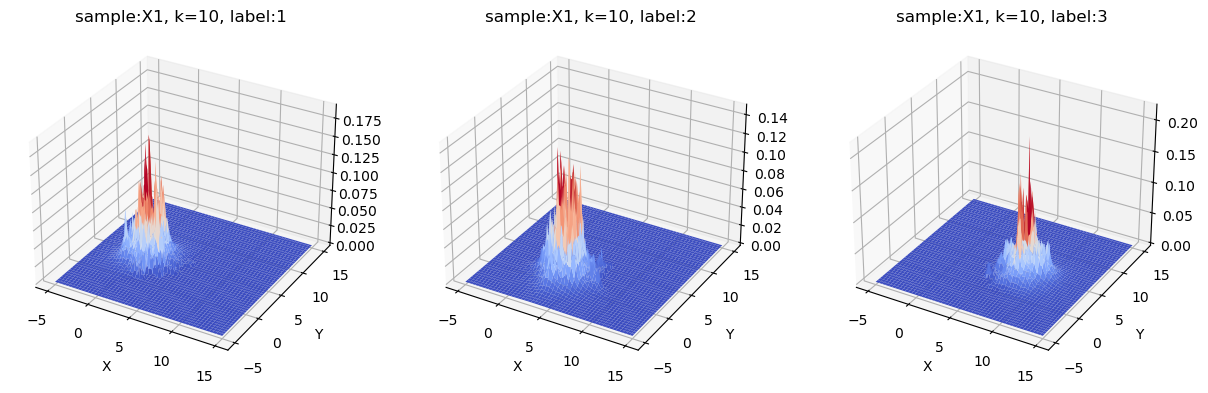

In [20]:
# 画图
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1,projection='3d')
ax.plot_surface(X, Y, Z0,cmap=plt.cm.coolwarm)
ax.set_title(f"sample:X1, k={k}, label:1")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 2,projection='3d')
ax.plot_surface(X, Y, Z1,cmap=plt.cm.coolwarm)
ax.set_title(f"sample:X1, k={k}, label:2")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 3,projection='3d')
ax.plot_surface(X, Y, Z2,cmap=plt.cm.coolwarm)
ax.set_title(f"sample:X1, k={k}, label:3")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

#### k = 30

In [21]:
k = 30

In [22]:
p = Kneibor_Eval(X1, [1, 2, 3], k)  # 获得概率密度估计

X, Y = np.mgrid[-5:15:200j, -5:15:200j]
Z0 = p[:, :, 0]
Z1 = p[:, :, 1]
Z2 = p[:, :, 2]

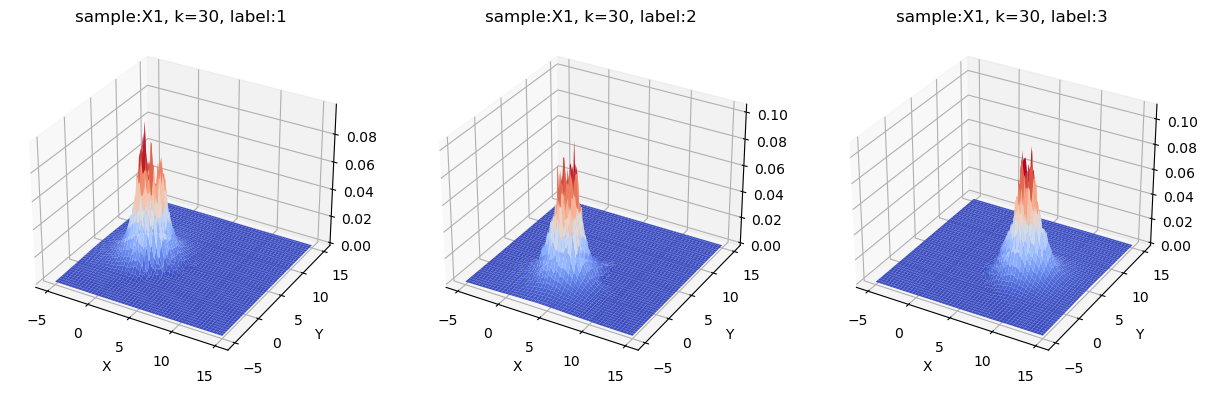

In [23]:
# 画图
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1,projection='3d')
ax.plot_surface(X, Y, Z0,cmap=plt.cm.coolwarm)
ax.set_title(f"sample:X1, k={k}, label:1")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 2,projection='3d')
ax.plot_surface(X, Y, Z1,cmap=plt.cm.coolwarm)
ax.set_title(f"sample:X1, k={k}, label:2")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 3,projection='3d')
ax.plot_surface(X, Y, Z2,cmap=plt.cm.coolwarm)
ax.set_title(f"sample:X1, k={k}, label:3")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

#### k = 50

In [24]:
k = 50

In [25]:
p = Kneibor_Eval(X1, [1, 2, 3], k)  # 获得概率密度估计

X, Y = np.mgrid[-5:15:200j, -5:15:200j]
Z0 = p[:, :, 0]
Z1 = p[:, :, 1]
Z2 = p[:, :, 2]

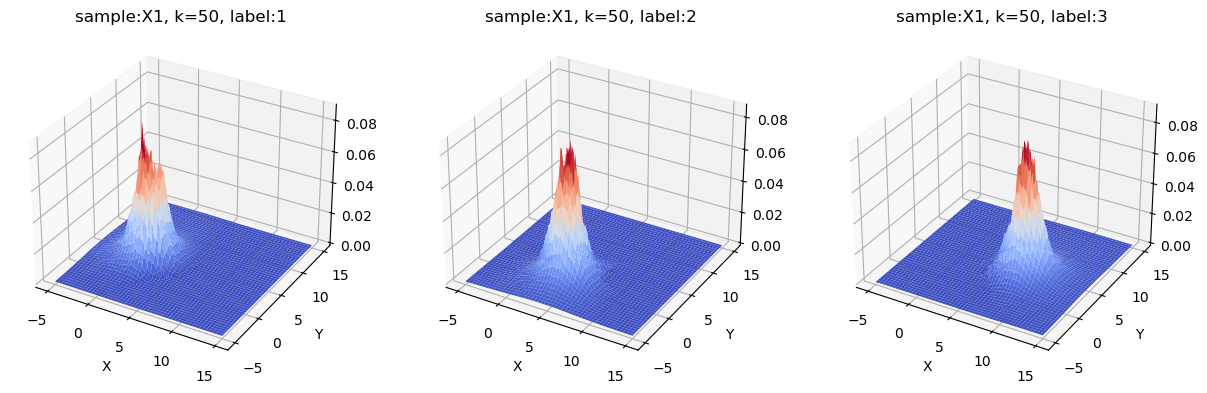

In [26]:
# 画图
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1,projection='3d')
ax.plot_surface(X, Y, Z0,cmap=plt.cm.coolwarm)
ax.set_title(f"sample:X1, k={k}, label:1")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 2,projection='3d')
ax.plot_surface(X, Y, Z1,cmap=plt.cm.coolwarm)
ax.set_title(f"sample:X1, k={k}, label:2")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 3,projection='3d')
ax.plot_surface(X, Y, Z2,cmap=plt.cm.coolwarm)
ax.set_title(f"sample:X1, k={k}, label:3")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

### 结果分析
从上方k分别为10、30、50的三组图片可以看出，k越大，估计出的概率密度越趋向于高斯分布。